In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
plt.rcParams.update({'font.size': 18})
import utils
from LinearAlignment import LinearAlignment

[NbConvertApp] WARNING | pattern 'utils_edit_mb.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write notebook output to std

In [2]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise

    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id]


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [3]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [4]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

In [5]:
def stretch_simulated_feats(data, stretch,true_feats = 'position',
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    if true_feats == 'position':
        true_feats_list = ['x','y','z']
    elif true_feats == 'velocity':
        true_feats_list = ['Vx','Vy','Vz']
    elif true_feats == 'all':
        true_feats_list = ['x','y','z'] + ['Vx','Vy','Vz']
    else:
        true_feats_list = true_feats
    
    for feature in true_feats_list:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

def amp_sim_feats(data, amp_stretch,feats = ['Vx_sim','Vy_sim','Vz_sim'],
                           suffix="_stretch_amp"):
    '''
    vary amplitude for simulation to better match true data,
    for a single sattelite;
    use predetermined amp_stretch coefficient (depends on the satellite)
    
    '''
    if feats == 'position':
        feats_list = ['x_sim','y_sim','z_sim']
    elif feats == 'velocity':
        feats_list = ['Vx_sim','Vy_sim','Vz_sim']
    elif feats == 'all':
        feats_list = ['x_sim','y_sim','z_sim'] + ['Vx_sim','Vy_sim','Vz_sim']
    else:
        feats_list = feats
        
    for feature in feats_list:
        data[feature+suffix] = amp_stretch*data[feature]
    
    return data

## Loading the data

In [7]:
data = pd.read_csv('data/train.csv', index_col = 'id')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
data['epoch'] = data['epoch'] - data['epoch'][0]

In [8]:
#data.head(1)

In [9]:
test_data = pd.read_csv('data/test.csv', index_col = 'id')
test_data['time'] = test_data['epoch']
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)
test_data['epoch'] = test_data['epoch'] - data['epoch'][0]

In [10]:
#test_data.head()

Track 1 train data only

In [11]:
sat_t1 = test_data['sat_id'].unique()
data = data[data['sat_id'].isin(sat_t1)]

### Remove time jumps: track 1

remove_time_jumps_fast on all track1 satellites only, compute smape

In [12]:
pd.options.mode.chained_assignment = None
remove_jumps = pd.DataFrame([])
for sat_id in tqdm(sat_t1):
    try:
        sat_data = get_satellite_data(data, sat_id)
        n_first = sat_data.shape[0]
        test_sat_data = get_satellite_data(test_data, sat_id)
        sat_data = pd.concat([sat_data,test_sat_data], axis = 0, sort = False)
                
        index = sat_data.index
        pred = pd.DataFrame(index = index )
        
        sat_data = remove_time_jumps_fast(sat_data.reset_index(drop=True))
        sat_data.set_index(index)
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    remove_jumps = remove_jumps.append(sat_data)

100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


In [13]:
remove_jumps_train = remove_jumps.dropna()

In [14]:
target_list = ['x','y','z','Vx','Vy','Vz']
feature_list = [f+'_sim' for f in target_list]

In [15]:
smape_remove_jumps = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_train,sat)
    smape_remove_jumps.append(smape(d[feature_list].to_numpy(),d[target_list].to_numpy()))

### Add linear alignment
after having removed time jumps

In [17]:
alignment_model = LinearAlignment()
transf_df = pd.DataFrame([])
for sat_id in tqdm(sat_t1):
    try:
        sat_data = get_satellite_data(remove_jumps, sat_id)
        n_first = sat_data.shape[0] - sat_data['x'].isnull().sum()
        index = sat_data.index
        pred = pd.DataFrame(index = index)
        sat_data.set_index(index)
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    
    n_train = 4*len(sat_data) // 10
    train_sat_data = sat_data[:n_train]
    
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:
        for feature_name in target_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)

            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            if utils.smape(option1[n_train:n_first],sat_data[feature_name].values[n_train:n_first]) < utils.smape(option2[n_train:n_first],sat_data[feature_name].values[n_train:n_first]):
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=-sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=-sat_data[feature_name].iloc[:n_first].values)

                pred[f'{feature_name}_sim'] = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            else:
                alignment_model.fit(t=sat_data['epoch'].iloc[:n_first].values,
                                x=sat_data[f'{feature_name}_sim'].iloc[:n_first].values,
                                gt=sat_data[feature_name].iloc[:n_first].values)
                pred[f'{feature_name}_sim']  = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)

            pred.loc[:,feature_name]=sat_data.loc[:, feature_name].values

    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    transf_df = transf_df.append(pred)

100%|██████████| 300/300 [02:42<00:00,  1.85it/s]


In [19]:
remove_jumps_la = transf_df.copy()
remove_jumps_la_train = remove_jumps_la.dropna()

In [20]:
smape_remove_jumps_la = []
for sat in sat_t1:
    d = get_satellite_data(remove_jumps_la_train,sat)
    smape_remove_jumps_la.append(smape(d[feature_list].to_numpy(),d[target_list].to_numpy()))

### Stretch horizontally

Will find one coefficient for x,y,z and another for Vx,Vy,Vz; that is best in terms of smape on train data.

In [31]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [24]:
stretch_dict_vel = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        d = stretch_simulated_feats(d,i,true_feats='velocity',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_vel[sat] = best[0]

100%|██████████| 300/300 [00:12<00:00, 23.37it/s]


In [32]:
extreme_stretch = [k for k,v in stretch_dict_vel.items() if (v <= 0.98 or v >= 1.02)]
extreme_stretch

[26, 35, 252, 277, 391, 515]

In [33]:
for sat in extreme_stretch:
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.94,1.06,0.005):
        d = stretch_simulated_feats(d,i,true_feats = 'velocity')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_vel[sat] = best[0]

In [34]:
extreme_stretch = [k for k,v in stretch_dict_vel.items() if (v <= 0.94 or v >= 1.06)]
extreme_stretch

[]

In [35]:
stretch_dict_vel = {int(k):v for k,v in stretch_dict_vel.items()}

#save stretch_dict
import json
#with open('stretch_dict_vel.txt', 'w') as file:
#    json.dump(stretch_dict_vel, file)

with open('stretch_dict_vel.txt', 'r') as file:
    stretch_dict_vel = json.load(file)

In [36]:
#position
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]
stretch_dict_pos = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        d = stretch_simulated_feats(d,i,true_feats='position',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

100%|██████████| 300/300 [00:13<00:00, 23.06it/s]


In [37]:
extreme_stretch = [k for k,v in stretch_dict_pos.items() if (v <= 0.98 or v >= 1.02)]
extreme_stretch

[252, 277, 391, 438, 515]

In [44]:
for sat in extreme_stretch:
    d = get_satellite_data(remove_jumps_train, sat)
    
    stretch_list = []
    for i in np.arange(0.9,1.1,0.005):
        d = stretch_simulated_feats(d,i,true_feats = 'position')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

In [45]:
extreme_stretch = [k for k,v in stretch_dict_pos.items() if (v <= 0.9 or v >= 1.1)]
extreme_stretch

[]

In [46]:
stretch_dict_pos = {int(k):v for k,v in stretch_dict_pos.items()}
#save stretch_dict
import json
#with open('stretch_dict_pos.txt', 'w') as file:
#    json.dump(stretch_dict_pos, file)

with open('stretch_dict_pos.txt', 'r') as file:
    stretch_dict_pos = json.load(file)

### Horizontal stretch after LA

In [47]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [53]:
stretch_dict_la_vel = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_la_train, sat)
    
    stretch_list = []
    for i in np.arange(0.95,1.05,0.005):
        d = stretch_simulated_feats(d,i,true_feats='velocity',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_la_vel[sat] = best[0]

100%|██████████| 300/300 [00:25<00:00, 11.57it/s]


In [54]:
extreme_stretch = [k for k,v in stretch_dict_la_vel.items() if (v <= 0.95 or v >= 1.05)]
extreme_stretch

[]

In [55]:
stretch_dict_la_vel = {int(k):v for k,v in stretch_dict_la_vel.items()}
#save stretch_dict
import json
#with open('stretch_dict_la_vel.txt', 'w') as file:
#    json.dump(stretch_dict_la_vel, file)

with open('stretch_dict_la_vel.txt', 'r') as file:
    stretch_dict_la_vel = json.load(file)

In [56]:
#position
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]
stretch_dict_la_pos = {}
for sat in tqdm(sat_t1):
    d = get_satellite_data(remove_jumps_la_train, sat)
    
    stretch_list = []
    for i in np.arange(0.96,1.04,0.005):
        d = stretch_simulated_feats(d,i,true_feats='position',suffix='_stretch')
        metric = smape(d[true_feats].to_numpy(),d[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_la_pos[sat] = best[0]

100%|██████████| 300/300 [00:23<00:00, 12.68it/s]


In [62]:
extreme_stretch = [k for k,v in stretch_dict_la_pos.items() if (v <= 0.96 or v >= 1.04)]
extreme_stretch

[]

In [60]:
stretch_dict_la_pos = {int(k):v for k,v in stretch_dict_la_pos.items()}
#save stretch_dict
import json
#with open('stretch_dict_la_pos.txt', 'w') as file:
#    json.dump(stretch_dict_la_pos, file)

with open('stretch_dict_la_pos.txt', 'r') as file:
    stretch_dict_la_pos = json.load(file)

## Stretch amplitude, individually for each feature

In [71]:
amp_dict_pos = {}
for dim in ['x','y','z']:
    amp_dict_pos[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

100%|██████████| 300/300 [00:31<00:00,  9.66it/s]


In [73]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'x': [], 'y': [515], 'z': [515]}

In [74]:
for dim in ['x','y','z']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

In [75]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

{'x': [], 'y': [], 'z': []}

In [77]:
for dim in ['x','y','z']:
    amp_dict_pos[dim] = {int(k):v for k,v in amp_dict_pos[dim].items()}
#save stretch_dict
import json
#with open('amp_dict_pos.txt', 'w') as file:
#    json.dump(amp_dict_pos, file)

with open('amp_dict_pos.txt', 'r') as file:
    amp_dict_pos = json.load(file)

In [85]:
amp_dict_vel = {}
for dim in ['Vx','Vy','Vz']:
    amp_dict_vel[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_vel[dim][sat] = best[0]

100%|██████████| 300/300 [00:32<00:00,  9.29it/s]


In [89]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_vel[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'Vx': [391, 515], 'Vy': [127, 252], 'Vz': []}

In [90]:
for dim in ['Vx','Vy','Vz']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.01):
            d = get_satellite_data(remove_jumps_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_vel[dim][sat] = best[0]

In [92]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_vel[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

{'Vx': [], 'Vy': [], 'Vz': []}

In [94]:
for dim in ['Vx','Vy','Vz']:
    amp_dict_vel[dim] = {int(k):v for k,v in amp_dict_vel[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_vel.txt', 'w') as file:
#    json.dump(amp_dict_vel, file)

with open('amp_dict_vel.txt', 'r') as file:
    amp_dict_vel = json.load(file)

## Amplitude stretch after LA

In [97]:
amp_dict_la_pos = {}
for dim in ['x','y','z']:
    amp_dict_la_pos[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_la_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_la_pos[str(sat)],true_feats = 'position',suffix='')
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_la_pos[dim][sat] = best[0]

100%|██████████| 300/300 [00:28<00:00, 10.36it/s]


In [98]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict_la_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp

{'x': [], 'y': [], 'z': []}

In [99]:
for dim in ['x','y','z']:
    amp_dict_la_pos[dim] = {int(k):v for k,v in amp_dict_la_pos[dim].items()}
#save stretch_dict
#import json
#with open('amp_dict_la_pos.txt', 'w') as file:
#    json.dump(amp_dict_la_pos, file)

with open('amp_dict_la_pos.txt', 'r') as file:
    amp_dict_la_pos = json.load(file)

In [100]:
amp_dict_la_vel = {}
for dim in ['Vx','Vy','Vz']:
    amp_dict_la_vel[dim] = {}
    for sat in tqdm(sat_t1):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(remove_jumps_la_train,sat)
            d = stretch_simulated_feats(d,stretch_dict_la_vel[str(sat)],true_feats = 'velocity',suffix='')
            d = amp_sim_feats(d,i,feats = 'velocity',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_la_vel[dim][sat] = best[0]

100%|██████████| 300/300 [00:30<00:00,  9.86it/s]


In [101]:
extreme_amp = {}
for dim in ['Vx','Vy','Vz']:
    extreme_amp[dim] = [k for k,v in amp_dict_la_vel[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp

{'Vx': [], 'Vy': [], 'Vz': []}

In [102]:
for dim in ['Vx','Vy','Vz']:
    amp_dict_la_vel[dim] = {int(k):v for k,v in amp_dict_la_vel[dim].items()}
#save stretch_dict
#import json
with open('amp_dict_la_vel.txt', 'w') as file:
    json.dump(amp_dict_la_vel, file)

with open('amp_dict_la_vel.txt', 'r') as file:
    amp_dict_la_vel = json.load(file)

### Compare SMAPE before and after LA (Linear Alignment)

In [31]:
target_list = ['x','y','z','Vx','Vy','Vz']
feature_list = [t+'_sim' for t in target_list]

In [43]:
smape(data[target_list],data[feature_list])

0.18024978428088173

In [27]:
no_la = [] #exclude from LA
#no_la = [372,587,523,473,514] #satellites excluded from LA by Tanya
la_list = [s for s in satellites_list if s not in no_la]
len(la_list)

300

In [46]:
smape_noLA = []
smape_LA = []
for sat in satellites_list:
    no_transf = get_satellite_data(data,sat)
    transf = get_satellite_data(transf_df_train,sat)
    smape_noLA.append((sat,smape(no_transf[feature_list],no_transf[target_list])))
    smape_LA.append((sat,smape(transf[feature_list],transf[target_list])))

In [53]:
no_LA = [] #satellites that do not benefit from LA (with respect to Smape)
for i in range(len(satellites_list)):
    if smape_noLA[i][1] < smape_LA[i][1]:
        no_LA.append((smape_LA[i][0]))

In [57]:
print('number of satellites for which remove time jumps with LA did not improve smape:', len(no_LA))

number of satellites for which remove time jumps with LA did not improve smape: 49


Do not perform remove time jumps but only LA: does not improve smape for any satellite.

In [192]:
df_list = [get_satellite_data(no_jumps_df,i) for i in satellites_list]

### Find best horizontal stretch, position, then velocity

In [162]:
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict[str(int(df['sat_id'].unique()))],true_feats='velocity',suffix='')
    df = stretch_simulated_feats(df,stretch_dict_pos[str(int(df['sat_id'].unique()))],true_feats='position',suffix='')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [163]:
no_jumps_stretch = pd.concat(df_list,axis=0,sort=False)

In [185]:
amp_dict_pos = {}
for dim in ['x','y','z']:
    amp_dict_pos[dim] = {}
    for sat in satellites_list:
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            d = get_satellite_data(no_jumps_stretch,sat)
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [188]:
extreme_amp_pos = {}
for dim in ['x','y','z']:
    extreme_amp_pos[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
extreme_amp_pos

{'x': [], 'y': [515], 'z': [515]}

In [189]:
for dim in ['x','y','z']:
    for sat in extreme_amp_pos[dim]:
        amplitude_list = []
        for i in np.arange(0.01,2.9,0.01):
            d = get_satellite_data(no_jumps_stretch,sat)
            d = amp_sim_feats(d,i,feats = 'position',suffix='')
            metric = smape(d['{}'.format(dim)].to_numpy(),d['{}_sim'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [190]:
extreme_amp_pos = {}
for dim in ['x','y','z']:
    extreme_amp_pos[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.01 or v >= 2.9)]
extreme_amp_pos

{'x': [], 'y': [], 'z': []}

In [191]:
with open('amp_dict_pos.txt', 'w') as file:
    json.dump(amp_dict_pos, file)

#with open('amp_dict_pos.txt', 'r') as file:
#    amp_dict_pos = json.load(file)

TypeError: keys must be str, int, float, bool or None, not int64

In [138]:
for dim in ['x','y','z']:
    amp_dict[dim] = {int(k):v for k,v in amp_dict[dim].items()}
    amp_dict_pos[dim] = {int(k):v for k,v in amp_dict_pos[dim].items()}

In [140]:
#amplitude stretch
for df in df_list:
    for dim in ['x','y','z']:
        #print(dim)
        amp = amp_dict[dim][int(df['sat_id'].unique())]
        #print(amp)
        df['V{}_sim'.format(dim)] = amp*df['V{}_sim'.format(dim)]
    for dim in ['x','y','z']:
        amp = amp_dict_pos[dim][int(df['sat_id'].unique())]
        df['{}_sim'.format(dim)] = amp*df['{}_sim'.format(dim)]
        
#predicted velocities 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [155]:
no_jumps_stretch.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time,t,dt
688,1.393565e+18,597,77054.582572,-59078.354514,-563.112863,-0.803702,-1.297028,0.161964,77054.582572,-59078.354514,-568.800871,-0.803702,-1.297028,0.163600,2014-02-28T05:19:01.386,16129.221544,0.085244
689,1.393572e+18,597,70256.332335,-67906.739391,631.885724,-1.037560,-1.095490,0.161841,70256.332335,-67906.739391,638.268409,-1.037560,-1.095490,0.163476,2014-02-28T07:21:46.454,16129.306788,0.085244
690,1.393579e+18,597,61829.238915,-75160.476673,1811.963846,-1.246389,-0.869204,0.157954,61829.238915,-75160.476673,1830.266511,-1.246389,-0.869204,0.159549,2014-02-28T09:24:31.522,16129.392032,0.085244
691,1.393587e+18,597,51953.463644,-80650.378576,2949.138477,-1.431064,-0.616020,0.150188,51953.463644,-80650.378576,2978.927754,-1.431064,-0.616020,0.151705,2014-02-28T11:27:16.590,16129.477275,0.085244
692,1.393594e+18,597,40809.611234,-84165.238391,4013.610759,-1.590525,-0.332080,0.138156,40809.611234,-84165.238391,4054.152281,-1.590525,-0.332080,0.139551,2014-02-28T13:30:01.658,16129.562519,0.085244


In [82]:
smape_00 = [s[1] for s in smape_nojumps]
smape_01 = [s[1] for s in smape_LA_nojumps]
smape_10 = [s[1] for s in smape_noLA]
smape_11 = [s[1] for s in smape_LA]

In [89]:
smapes = list(zip(satellites_list, smape_11,smape_10,smape_01,smape_00))

In [61]:
no_LA_yes_jumps = [] #satellites that do not benefit from LA (with respect to Smape) after jumps removed
for i in range(len(satellites_list)):
    if smape_nojumps[i][1] < smape_LA[i][1]:
        no_LA_yes_jumps.append((smape_LA[i][0]))

Best choice of transformation for each satellite according to lowest smape in train data.

Code is: 

1. yes time jumps, yes LA
2. yes time jumps, no LA
3. no time jumps, yes LA (this never happens)
4. no time jumps, no LA

In [99]:
best_choice = []
for i in range(len(satellites_list)):
    best_choice.append((smapes[i][0],smapes[i].index(min(smapes[i]))))

False

## Train test split

Now split the train data set to train/test for RF model.

In [93]:
def train_test_split(df,col = 'sat_id',ratio = 0.8,targets = ['x','y','z','Vx','Vy','Vz']):
    '''
    train test split for our train data, 
    default, 80% train for each satellite, 20% test
    '''
    sat_list = df[col].unique()
    train_df = pd.DataFrame([])
    test_df = pd.DataFrame([])
    for sat in sat_list:
        sat_df = get_satellite_data(df,sat)
        n = int(ratio*sat_df.shape[0])
        train_df = train_df.append(sat_df[:n])
        test_df = test_df.append(sat_df[n:])
    Y_train = train_df[targets]
    Y_test = test_df[targets]
    X_train = train_df.drop(targets,axis=1)
    X_test = test_df.drop(targets,axis=1)
    return X_train, X_test, Y_train, Y_test       

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(data)

In [109]:
#checking indices match
for sat in X_train['sat_id'].unique():
    if X_train[X_train['sat_id']==sat].index[-1] + 1 != X_test[X_test['sat_id']==sat].index[0]:
        print(sat)

In [113]:
(Y_test.index != X_test.index).sum()

0

In [114]:
(Y_train.index != X_train.index).sum()

0

### Random forest

First remove time jumps and run linear alignment on train data.

In [35]:
sat_track1 = test_data['sat_id'].unique()

In [36]:
features_list
feat_sim = [feat+'_sim' for feat in features_list]
feat_sim

['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

In [40]:
data2 = transf_df.copy()
#print('shape',data2.shape)
for feat in feat_sim:
    data2[feat+'_shift'] = data2.groupby(['sat_id'])[feat].shift()
    #print('shape',data2.shape)
    data2[feat+'_diff'] = data2.groupby(['sat_id'])[feat].diff()
    #print('shape',data2.shape)
data2 = data2.fillna(0)
#print(data2.isna().sum())
#print('shape',data2.shape)
data2.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,...,y_sim_shift,y_sim_diff,z_sim_shift,z_sim_diff,Vx_sim_shift,Vx_sim_diff,Vy_sim_shift,Vy_sim_diff,Vz_sim_shift,Vz_sim_diff
0,1.388534e+18,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.388536e+18,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872,11199.853336,5102.405255,...,-2771.180760,7873.586015,3166.926302,-4012.856665,2.508879,-3.639871,6.152996,-0.330693,-2.826227,-0.423822
2,1.388537e+18,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441,8239.504004,11465.137350,...,5102.405255,6362.732095,-845.930363,-3834.361515,-1.130992,-2.096365,5.822303,-1.698371,-3.250049,0.549794
3,1.388538e+18,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151,3569.107805,15652.050271,...,11465.137350,4186.912921,-4680.291877,-2970.049329,-3.227356,-0.732859,4.123931,-1.603024,-2.700255,0.723532
4,1.388539e+18,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512,-1566.253652,18042.143340,...,15652.050271,2390.093069,-7650.341207,-2100.641414,-3.960215,-0.086790,2.520907,-1.223282,-1.976723,0.629713


Train separate model for each of 6 predictors:

In [22]:
transf_df.shape

(599254, 17)

## Try VAR, first check stationarity with Augmented Dickey-Fuller test

In [15]:
data.shape

(649912, 15)

In [14]:
from statsmodels.tsa.stattools import adfuller
X = data[data['sat_id']==0]['x'].to_numpy()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -6.748226
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [17]:
sub = pd.read_csv('data/submission.csv')

In [26]:
sub_index = sub.id.values
sub.head()

,id,x,y,z,Vx,Vy,Vz
0,3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [50]:
q = transf_df.loc[sub_index,['x_sim', 'y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]
q.columns = ['x','y','z','Vx','Vy','Vz']
# q = q.reset_index()
q.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-20234.180106,-12554.021795,5667.646483,3.484611,-1.868028,1.264194
3928,-15637.292764,-14050.528821,6744.069301,4.259422,-1.473909,1.107679
3929,-10053.451592,-14556.910761,7218.956173,5.013412,-0.863050,0.828353
3930,-3550.183845,-13505.949633,6663.844298,5.505161,0.093000,0.343701
3931,3426.309269,-10067.615863,4482.599249,5.003614,1.593562,-0.487549


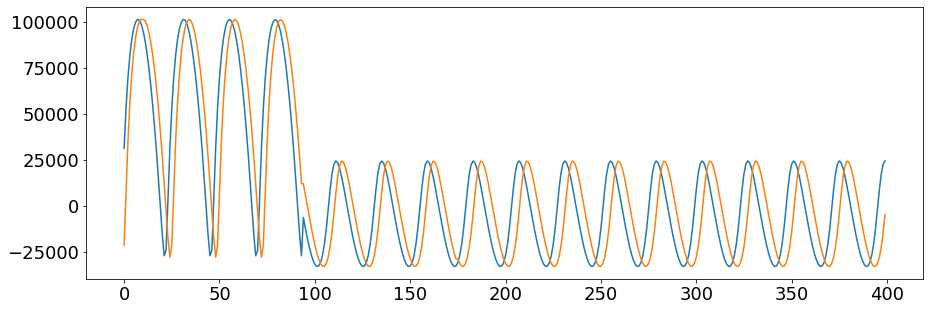

In [51]:
plt.figure(figsize=(15, 5))

plt.plot(sub.x.iloc[2500:2900].values)

plt.plot(q.x.iloc[2500:2900].values)

In [52]:
import datetime

submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
q.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

q.head(10)

Submission saved to submission_2020-01-28_12-30-56.csv


,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-20234.180106,-12554.021795,5667.646483,3.484611,-1.868028,1.264194
3928,-15637.292764,-14050.528821,6744.069301,4.259422,-1.473909,1.107679
3929,-10053.451592,-14556.910761,7218.956173,5.013412,-0.863050,0.828353
3930,-3550.183845,-13505.949633,6663.844298,5.505161,0.093000,0.343701
3931,3426.309269,-10067.615863,4482.599249,5.003614,1.593562,-0.487549
3932,9280.388630,-3651.655477,671.408666,2.283048,3.815583,-1.798337
3933,11346.640325,4200.805203,-3491.808855,-1.415976,5.960476,-3.128370
3934,9049.838121,10744.704564,-6777.020430,-3.549033,5.961191,-3.276736
3935,4357.666442,15028.859712,-9009.787419,-4.222716,4.300133,-2.524444


### Period

In [1]:
def cycle_lengths(t,x):
    '''
    Find cycle lengths; input t = time array or series and x = position or velocity
    '''
    spl = InterpolatedUnivariateSpline(t, x)
    roots = spl.roots()
    half_periods = np.diff(spl.roots())
    periods = np.add.reduceat(half_periods, np.arange(0, len(half_periods), 2))
    if len(half_periods)%2 != 0: #if odd # of observations, remove last (invalid) half period
        periods = periods[:-1]
    return periods

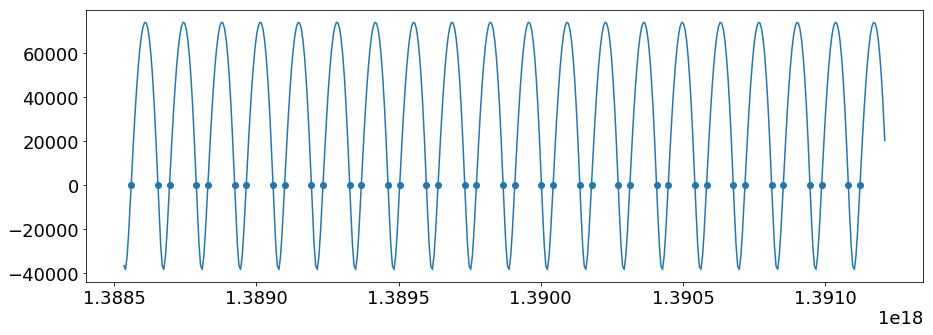

In [12]:
d = data[data.sat_id == 317]
td = test_data[test_data.sat_id == 317]
new = pd.concat([d,td],  axis = 0, sort = False)
spl = InterpolatedUnivariateSpline(d['epoch'], d['x'])
roots = spl.roots()
plt.figure(figsize=(15, 5))
#plt.plot(new['epoch'],new['x_sim'])
plt.plot(d['epoch'],d['x'])
plt.scatter(roots,[0]*len(roots));

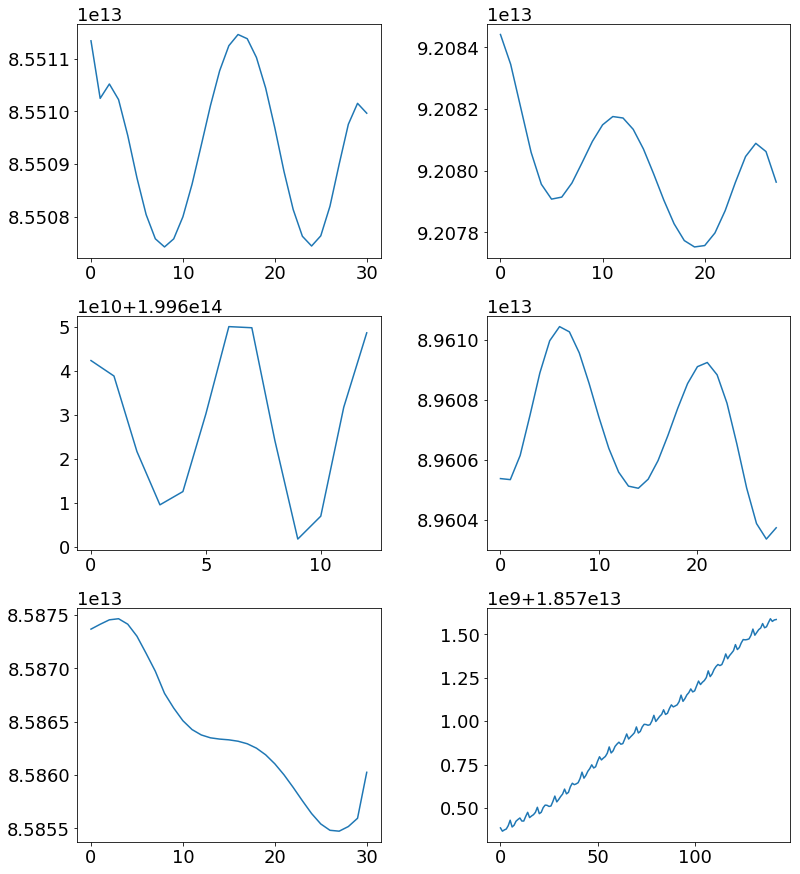

In [26]:
d = data[data.sat_id == 302]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig = plt.figure()
fig.add_subplot(321)
plt.plot(periods);

d = data[data.sat_id == 303]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(322)
plt.plot(periods);

d = data[data.sat_id == 304]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(323)
plt.plot(periods);

d = data[data.sat_id == 305]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(324)
plt.plot(periods);

d = data[data.sat_id == 306]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(325)
plt.plot(periods);

d = data[data.sat_id == 307]
periods = cycle_lengths(d['epoch'],d['Vz'])
fig.add_subplot(326)
plt.plot(periods);

plt.subplots_adjust(top=2.92, bottom=0.08, left=0.30, right=1.95, hspace=0.25,
                    wspace=0.35)

plt.show();